# How to Perform Multivariate Outlier Detection in Python PyOD For Machine Learning
## Outlier detection series, part 3
![](images/unsplash.jpg)

<figcaption style="text-align: center;"><figcaption/>
Photo by <a href="https://unsplash.com/@miyatankun?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Takashi Miyazaki</a> on <a href="https://unsplash.com/backgrounds/art/abstract?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Motivation

### Multivariate outlier detection with PyOD

In [211]:
from pyod.models.lof import LOF

lof = LOF(n_neighbors=30).fit(X)

labels = pd.Series(lof.labels_)
outliers_X_lof = X[labels == 1]

num_outliers = len(outliers_X_lof)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.3f}")

The number of outliers: 5394
Percentage of outliers: 0.100


In [214]:
from pyod.models.iforest import IForest

iforest = IForest(n_estimators=500).fit(X)

labels = pd.Series(iforest.labels_)
outliers_X_iforest = X[labels == 1]

num_outliers = len(outliers_X_iforest)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.3f}")

The number of outliers: 5394
Percentage of outliers: 0.100


### Contamination

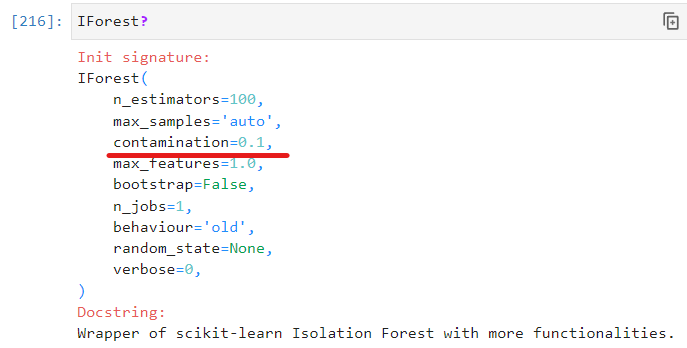

In [217]:
iforest = IForest().fit(X)

iforest.decision_scores_[:10]

array([-0.01789882,  0.03646687,  0.09759012, -0.06977119, -0.02610138,
        0.01991868,  0.00180873, -0.00440727,  0.08668909,  0.04439745])

In [218]:
from pyod.models.knn import KNN

knn = KNN().fit(X)

knn.decision_scores_[:10]

array([11.56034602, 12.46189392, 13.42818305,  6.09343909,  5.39804594,
        5.90354978,  5.12414871,  5.41214375,  8.1313775 ,  6.87590721])

### Probability scores

In [227]:
from pyod.models.iforest import IForest

iforest = IForest(n_estimators=1000).fit(X)

probs = iforest.predict_proba(X)
probs[:10]

array([[0.6595839 , 0.3404161 ],
       [0.49970223, 0.50029777],
       [0.30612256, 0.69387744],
       [0.73151238, 0.26848762],
       [0.58695384, 0.41304616],
       [0.42048955, 0.57951045],
       [0.53045075, 0.46954925],
       [0.6171362 , 0.3828638 ],
       [0.33290998, 0.66709002],
       [0.46752207, 0.53247793]])

In [230]:
threshold = 0.9

is_outlier = probs[:, 1] > threshold
outliers_X_probs = X[is_outlier]

num_outliers = len(outliers_X_probs)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(X):.4f}")

The number of outliers: 10
Percentage of outliers: 0.0002
